<a href="https://colab.research.google.com/github/ilkelatifoglu/BTO-Core/blob/main/FinalCode_all_integrated_with_FocalLoss_AugmentationCorrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
%%capture
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from scipy.signal import butter, filtfilt, find_peaks
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from collections import Counter
import os
from google.colab import drive
from torchvision import transforms
from PIL import Image
import matplotlib.cm as mpl_cm
import torchvision.models as tv_models

drive.mount("/content/drive")
os.environ['DRIVE_PROJECT_DIR'] = '/content/drive/MyDrive/CS 464 Project'
os.environ['LOCAL_PROJECT_DIR'] = '/content/project_dir'

!mkdir -p "$LOCAL_PROJECT_DIR"
!rsync -azv --progress "$DRIVE_PROJECT_DIR/" "$LOCAL_PROJECT_DIR/"
drive.flush_and_unmount()

!apt-get install -y unzip
!unzip -o "$LOCAL_PROJECT_DIR/training2017-20250406T085129Z-001.zip" -d "$LOCAL_PROJECT_DIR/"

training_data = Path(os.environ["LOCAL_PROJECT_DIR"]) / "training2017"

reference_path = training_data / "REFERENCE.csv"
reference_df = pd.read_csv(reference_path, header=None, names=['record_name', 'label'])

label_map = {'N': 0, 'A': 1, 'O': 2, '~': 3}
reference_df['label_num'] = reference_df['label'].map(label_map)

In [10]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data preprocessing functions
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=300, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def segment_signal(signal, fs, segment_duration):
    segment_length = int(segment_duration * fs)
    num_segments = len(signal) // segment_length
    segments = [signal[i*segment_length:(i+1)*segment_length] for i in range(num_segments)]
    return segments

#def augment_time_shift(segment, fs, shift_max_seconds=0.5):
    #shift = np.random.randint(-int(shift_max_seconds*fs), int(shift_max_seconds*fs))
    #if shift > 0:
       # augmented = np.concatenate([np.zeros(shift), segment[:-shift]])
    #elif shift < 0:
      #  augmented = np.concatenate([segment[-shift:], np.zeros(-shift)])
    #else:
     #   augmented = segment.copy()
   # return augmented

#def augment_scaling(segment, scale_range=(0.9, 1.1)):
   # scale = np.random.uniform(*scale_range)
   # return segment * scale

#def augment_noise(segment, noise_level=0.01):
  # noise = np.random.normal(0, noise_level, segment.shape)
   # return segment + noise

##def augment_segment(segment, fs):
   # seg_aug = augment_time_shift(segment, fs)
   #seg_aug = augment_scaling(seg_aug)
   # seg_aug = augment_noise(seg_aug)
   #return seg_aug

def process_record(record_path, fs=300, segment_duration=30, augment_count=0):
    record = loadmat(record_path)
    ecg_signal = record['val'][0]

    # Apply bandpass filter
    # filtered_signal = bandpass_filter(ecg_signal, lowcut=0.5, highcut=40, fs=fs, order=4)
    filtered_signal = np.array(ecg_signal)

    # Normalize
    normalized_signal = (filtered_signal - np.mean(filtered_signal)) / np.std(filtered_signal)

    # Pad or truncate
    # required_length = segment_duration * fs
    # if len(normalized_signal) < required_length:
    #     pad_length = required_length - len(normalized_signal)
    #     normalized_signal = np.pad(normalized_signal, (0, pad_length), mode='constant')
    # else:
    #     normalized_signal = normalized_signal[:required_length * (len(normalized_signal) // required_length)]

    # Segment
    segments = segment_signal(normalized_signal, fs, segment_duration)

    # Augment
    augmented_segments = []
    #for seg in segments:
       # for _ in range(augment_count):
          #  augmented_seg = augment_segment(seg, fs)
           # augmented_segments.append(augmented_seg)

    return segments, augmented_segments

def segment_to_ecg_image(segment, fs=300, bar_height=32, cmap_name='viridis'):
    # Find R-peaks
    min_dist = int(0.25 * fs)
    peaks, _ = find_peaks(segment, distance=min_dist)
    amps = segment[peaks] if len(peaks) > 0 else np.array([0.0])
    # Normalize amplitudes to [0,1]
    amin, amax = amps.min(), amps.max()
    norm = (amps - amin)/(amax-amin) if amax>amin else np.zeros_like(amps)
    # Map to RGB via a matplotlib colormap
    cmap = mpl_cm.get_cmap(cmap_name)
    colors = (cmap(norm)[:, :3]*255).astype(np.uint8)
    # Build H×W×3 array (bars of height=bar_height)
    img_arr = np.tile(colors[np.newaxis,:,:], (bar_height,1,1))
    return Image.fromarray(img_arr, mode='RGB')

image_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])

class ECGImageDataset(Dataset):
    def __init__(self, segments, labels, transform=image_transform):
        self.segments = segments
        self.labels   = labels
        self.transform= transform
    def __len__(self): return len(self.segments)
    def __getitem__(self, idx):
        seg = self.segments[idx]
        img = segment_to_ecg_image(seg)
        img = self.transform(img)
        lbl = self.labels[idx]
        return img, torch.tensor(lbl, dtype=torch.long)

# Dataset class
class ECGSegmentDataset(Dataset):
    def __init__(self, segments, labels):
        self.segments = segments
        self.labels = labels

    def __len__(self):
        return len(self.segments)

    def __getitem__(self, idx):
        segment = self.segments[idx]
        segment = segment.reshape(1, -1)  # Shape: [1, 9000]
        label = self.labels[idx]  # Single integer label
        return torch.FloatTensor(segment), torch.tensor(label, dtype=torch.long)

# Model architectures
class ECG_CNN(nn.Module):
    def __init__(self, input_length=9000, num_classes=4):
        super(ECG_CNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm1d(32)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flattened_size = 128 * (input_length // 8)
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ECG_LSTM(nn.Module):
    lstm: nn.Module
    dense: nn.Module

    def __init__(self, input_length=9000, num_classes=4):
        super().__init__()
        self.lstm = nn.LSTM(1, 64, batch_first=True)
        self.dense1 = nn.Linear(64, 8)
        # self.dense1_5 = nn.Linear(128, 64)
        self.dense2 = nn.Linear(8, 4)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], x.shape[-1], 1))
        lstm_out, (ht, ct) = self.lstm(x)
        out = torch.max(lstm_out, dim=1)[0]
        dense1_in = out
        dense2_in = F.tanh(self.dense1(dense1_in))
        result = self.dense2(dense2_in)
        return result

class ECG_BILSTM(ECG_LSTM):
    def __init__(self, input_length=9000, num_classes=4):
        super().__init__()
        self.lstm = nn.LSTM(self.lstm.input_size, self.lstm.hidden_size, batch_first=True, bidirectional=True)
        self.dense1 = nn.Linear(self.lstm.hidden_size*2, self.dense1.out_features)

class ECG_RNN(nn.Module):
    def __init__(self, input_size=9000, hidden_size=64, num_layers=2, num_classes=4, bidirectional=True):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                          batch_first=True, bidirectional=bidirectional)
        self.proj = nn.Sequential(
            nn.Linear(hidden_size*(2 if bidirectional else 1), 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        out, _ = self.gru(x)
        h = out[:, -1, :]
        h = self.proj(h)
        return self.fc(h)

class ECG_TransferNet(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        # load and freeze EfficientNet-V2 backbone
        self.backbone = tv_models.efficientnet_v2_s(pretrained=True)
        for p in self.backbone.features.parameters():
            p.requires_grad = False
        # new head
        in_feats = self.backbone.classifier[1].in_features
        self.backbone.classifier[1] = nn.Linear(in_feats, num_classes)

    def forward(self, x):
        return self.backbone(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5):
    model = model.to(device)
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    best_val_loss = float('inf')
    trigger_times = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)  # Now shape: [batch_size]

            optimizer.zero_grad()
            outputs = model(inputs)  # Shape: [batch_size, num_classes]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).squeeze()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            trigger_times = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print("Early stopping!")
                break

    return model, {'train_losses': train_losses, 'val_losses': val_losses,
                  'train_accs': train_accs, 'val_accs': val_accs}

# Process files
def process_files(files, augment_count=0):
    all_segments = []
    labels = []
    for mat_file, label in files:
        segs, aug_segs = process_record(mat_file, augment_count=augment_count)
        all_segments.extend(segs + aug_segs)
        labels.extend([label] * (len(segs) + len(aug_segs)))
    return all_segments, labels

In [11]:
# Create file-label pairs
mat_files = list(training_data.glob("*.mat"))
file_label_pairs = []
for mat_file in mat_files:
    record_name = mat_file.stem
    if record_name in reference_df['record_name'].values:
        label = reference_df.loc[reference_df['record_name'] == record_name, 'label_num'].values[0]
        file_label_pairs.append((mat_file, label))

# Split data
files_train, files_val = train_test_split(
    file_label_pairs, test_size=0.2, random_state=42,
    stratify=[label for (file, label) in file_label_pairs]
)

# Apply basic augmentation during initial loading
train_segments, train_labels = process_files(files_train, augment_count=0)
val_segments, val_labels = process_files(files_val, augment_count=0)

# Class-balancing with advanced augmentation
print("Original class distribution:", np.bincount(train_labels, minlength=4))

# Get counts of each class
class_counts = np.bincount(train_labels, minlength=4)
max_count = max(class_counts)
print(f"Balancing classes to {max_count} samples each")

# Prepare for balanced dataset
balanced_segments = []
balanced_labels = []

# NOTE: always returns a numpy array
def augment_signal(signal, fs=300):
    # To Ensure signal is a numpy array and has the correct shape
    if signal is None or len(signal) == 0:
        # Return a copy of a default signal if input is invalid
        print("Warning: Invalid signal received for augmentation")
        return np.zeros(9000)  # Default signal length

    # Make a copy to avoid modifying the original
    signal = np.array(signal).copy()

    aug_type = np.random.choice(['shift', 'noise', 'scale', 'combined'], p=[0.3, 0.2, 0.2, 0.3])

    if aug_type == 'shift':
        # Time shift up to 5% of signal length
        shift = np.random.randint(-len(signal)//20, len(signal)//20)
        if shift > 0:
            return np.pad(signal[:-shift], (shift, 0), mode='edge')
        elif shift < 0:
            return np.pad(signal[-shift:], (0, -shift), mode='edge')
        else:
            return signal.copy()  # Explicit return for zero shift

    elif aug_type == 'noise':
        # Add Gaussian noise with small amplitude
        noise_level = np.random.uniform(0.01, 0.05) * np.std(signal)
        return signal + np.random.normal(0, noise_level, size=signal.shape)

    elif aug_type == 'scale':
        # Scale amplitude by a random factor
        scale = np.random.uniform(0.85, 1.15)
        return signal * scale

    else:  # 'combined'
        # Apply multiple augmentations
        augmented = signal.copy()
        # Small time shift
        shift = np.random.randint(-len(signal)//40, len(signal)//40)
        if shift > 0:
            augmented = np.pad(augmented[:-shift], (shift, 0), mode='edge')
        elif shift < 0:
            augmented = np.pad(augmented[-shift:], (0, -shift), mode='edge')
        # Scale with smaller range
        scale = np.random.uniform(0.9, 1.1)
        augmented = augmented * scale
        # Add small noise
        noise_level = np.random.uniform(0.005, 0.02) * np.std(signal)
        augmented = augmented + np.random.normal(0, noise_level, size=augmented.shape)
        return augmented

# For each class, keep all original samples and augment the rest
for class_idx in range(4):
    # Find indices of this class
    indices = np.where(np.array(train_labels) == class_idx)[0]

    if len(indices) == 0:
        print(f"Warning: No samples for class {class_idx}")
        continue

    # Add all original samples
    class_segments = [train_segments[i] for i in indices]
    balanced_segments.extend(class_segments)
    balanced_labels.extend([class_idx] * len(class_segments))

    # If we need more samples, create augmented versions
    if len(indices) < max_count:
        # Calculate how many more we need
        needed = max_count - len(indices)
        # Sample with replacement and augment
        for _ in range(needed):
            # Randomly select an original sample
            orig_idx = np.random.choice(indices)
            if orig_idx < len(train_segments):  # Safety check
                # Apply augmentation
                augmented = augment_signal(train_segments[orig_idx])
                if augmented is not None and len(augmented) > 0:  # Verify the result
                    balanced_segments.append(augmented)
                    balanced_labels.append(class_idx)
                else:
                    print(f"Warning: Augmentation returned None or empty for class {class_idx}")
            else:
                print(f"Warning: Invalid index {orig_idx} for class {class_idx}")

# Verify there are no None values or empty arrays
balanced_segments = [seg for seg in balanced_segments if seg is not None and len(seg) > 0]
balanced_labels = balanced_labels[:len(balanced_segments)]  # Trim labels to match

print(f"Final balanced dataset size: {len(balanced_segments)}")
print("Balanced class distribution:", np.bincount(balanced_labels, minlength=4))

# Replace original data with balanced data
train_segments = balanced_segments
train_labels = balanced_labels

# Create datasets
train_dataset = ECGSegmentDataset(train_segments, train_labels)
val_dataset = ECGSegmentDataset(val_segments, val_labels)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True) # Drop the last incomplete batch
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True) # Drop the last incomplete batch

# Dataset and loaders for transfer learning
train_image_dataset = ECGImageDataset(train_segments, train_labels)
val_image_dataset   = ECGImageDataset(val_segments,   val_labels)
train_image_loader  = DataLoader(train_image_dataset, batch_size=batch_size, shuffle=True,  drop_last=True)
val_image_loader    = DataLoader(val_image_dataset,   batch_size=batch_size, shuffle=False, drop_last=True)

# After creating the datasets, check the shapes
if len(train_dataset) > 0:
    sample_input, sample_label = train_dataset[0]
    print(f"Sample input shape: {sample_input.shape}")  # Should be [1, 9000]
    print(f"Sample label shape: {sample_label.shape}")  # Should be [] (scalar)
else:
    print("Warning: Empty train dataset!")

# Check for empty batches
for batch_idx, (inputs, labels) in enumerate(train_loader):
    print(f"First batch shape: {inputs.shape}, labels: {labels.shape}")
    break

Original class distribution: [3943  573 2079  120]
Balancing classes to 3943 samples each
Final balanced dataset size: 15772
Balanced class distribution: [3943 3943 3943 3943]
Sample input shape: torch.Size([1, 9000])
Sample label shape: torch.Size([])
First batch shape: torch.Size([32, 1, 9000]), labels: torch.Size([32])


In [12]:
class FocalLoss(nn.Module):
    """
    Focal Loss, as described in https://arxiv.org/abs/1708.02002.

    It modifies standard cross-entropy loss to focus learning on hard examples
    and down-weight easy examples. Useful for datasets with significant class
    imbalance.
    """
    def __init__(self, weight: torch.Tensor, gamma: float = 2.0):
        super().__init__()
        self.alpha = weight
        self.gamma = gamma

        self.alpha = self.alpha.to(dtype=torch.float32)


    def forward(self, predictions: torch.Tensor, actuals: torch.Tensor) -> torch.Tensor:
        """
        Parameters:
          - predictions (Tensor): Logits from the model
          - actuals (Tensor): Ground truth labels

        Returns:
            Tensor: Calculated focal loss.
        """
        num_classes = predictions.shape[1]

        if actuals.numel() == 0:
            return predictions.sum() * 0.0

        log_prob = F.log_softmax(predictions, dim=1)

        # Gather log probabilities corresponding to the true classes
        # Use view(-1, 1) to make actuals compatible with gather
        log_pt = log_prob.gather(1, actuals.view(-1, 1)).squeeze(1)

        pt = log_pt.exp()

        focal_weight = (1 - pt).pow(self.gamma)

        # Calculate the final loss: - alpha_t * (1 - pt) ** gamma * log_pt
        loss = -focal_weight * log_pt

        assert self.alpha.shape[0] == num_classes

        alpha_t = self.alpha.gather(0, actuals)

        loss = alpha_t * loss

        loss = loss.mean()

        return loss

In [13]:
# Compute class weights
unique_labels, counts = np.unique(train_labels, return_counts=True)
class_weights = torch.tensor(1 / (counts+1e-5), dtype=torch.float).to(device)
class_weights = F.normalize(class_weights, dim=-1)
criterion = FocalLoss(weight=class_weights)
print("The frequency of labels:", counts)
print("The weights of each label:", class_weights)

The frequency of labels: [3943 3943 3943 3943]
The weights of each label: tensor([0.5000, 0.5000, 0.5000, 0.5000], device='cuda:0')


In [14]:
# Train models
models = {
    # 'LSTM': ECG_LSTM(),
    #'BI-LSTM': ECG_BILSTM(),
    # 'CNN': ECG_CNN(),
    # 'RNN': ECG_RNN(),
    'Transfer': ECG_TransferNet()
}
results = {}
for name, model in models.items():
    print(f"\nTraining {name} model...")
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    if name == 'Transfer':
        dl_train, dl_val = train_image_loader, val_image_loader
    else:
        dl_train, dl_val = train_loader, val_loader

    trained_model, history = train_model(
        model, dl_train, dl_val, criterion, optimizer, num_epochs=5, patience=5
    )
    results[name] = {'model': trained_model, 'history': history}
    torch.save(trained_model.state_dict(), f'ecg_{name.lower()}_model.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Training Transfer model...


Epoch 1/5:   0%|          | 0/492 [00:00<?, ?it/s]<ipython-input-10-2e5273649a61>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl_cm.get_cmap(cmap_name)
Epoch 1/5: 100%|██████████| 492/492 [01:20<00:00,  6.13it/s]


Train Loss: 0.3548, Train Acc: 0.3784
Val Loss: 0.3333, Val Acc: 0.3858


Epoch 2/5: 100%|██████████| 492/492 [01:20<00:00,  6.12it/s]


Train Loss: 0.3247, Train Acc: 0.4439
Val Loss: 0.3193, Val Acc: 0.4117


Epoch 3/5: 100%|██████████| 492/492 [01:21<00:00,  6.06it/s]


Train Loss: 0.3163, Train Acc: 0.4616
Val Loss: 0.3286, Val Acc: 0.4129


Epoch 4/5: 100%|██████████| 492/492 [01:20<00:00,  6.11it/s]


Train Loss: 0.3087, Train Acc: 0.4705
Val Loss: 0.3142, Val Acc: 0.4147


Epoch 5/5: 100%|██████████| 492/492 [01:21<00:00,  6.06it/s]


Train Loss: 0.3061, Train Acc: 0.4794
Val Loss: 0.3089, Val Acc: 0.4243



Evaluating Transfer model...


<ipython-input-10-2e5273649a61>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl_cm.get_cmap(cmap_name)


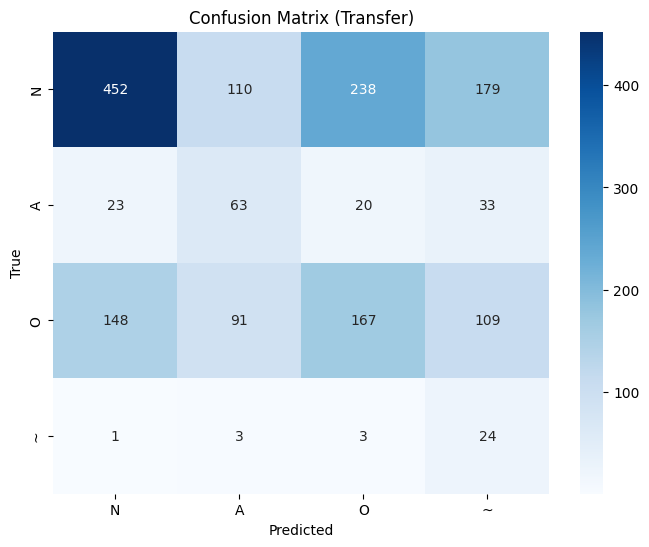

              precision    recall  f1-score   support

           N       0.72      0.46      0.56       979
           A       0.24      0.45      0.31       139
           O       0.39      0.32      0.35       515
           ~       0.07      0.77      0.13        31

    accuracy                           0.42      1664
   macro avg       0.36      0.50      0.34      1664
weighted avg       0.57      0.42      0.47      1664


Additional Metrics for Transfer:
Accuracy: 0.4243
Macro Precision: 0.3550
Macro Recall: 0.5033
Macro F1: 0.3390
Weighted Precision: 0.5679
Weighted Recall: 0.4243
Weighted F1: 0.4697


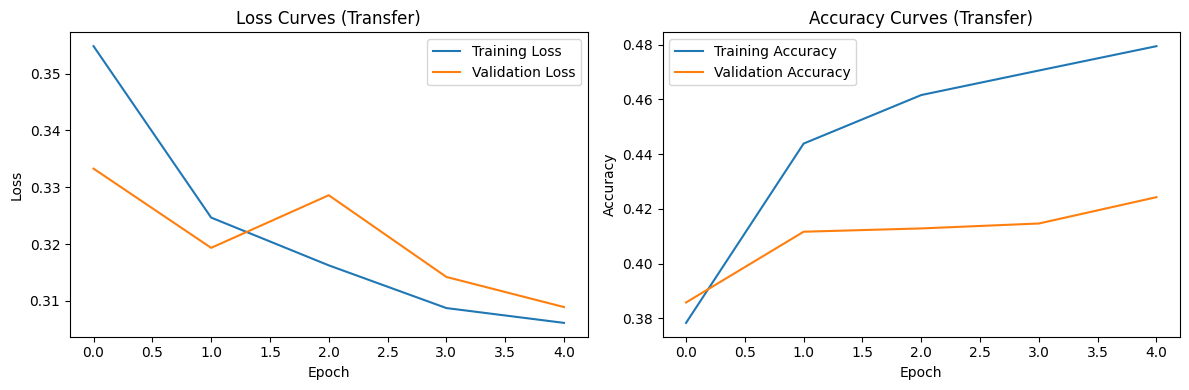

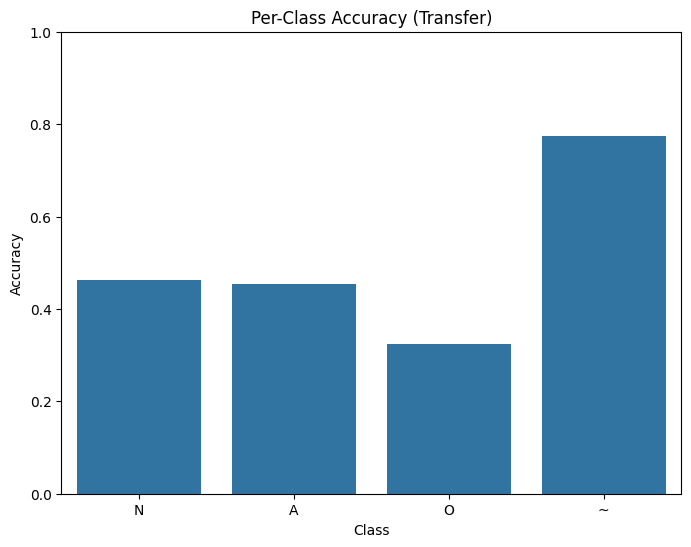


First misclassified example for Transfer:


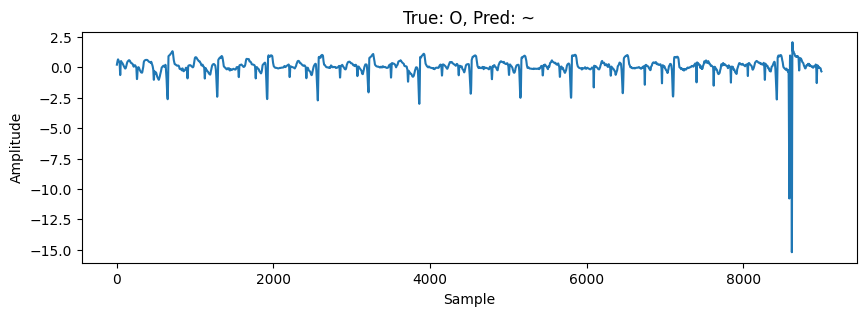

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).squeeze()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

for name in models.keys():
    print(f"\nEvaluating {name} model...")
    model = results[name]['model']
    if name == 'Transfer':
        loader = val_image_loader
    else:
        loader = val_loader

    val_labels, val_preds = evaluate_model(model, loader)

    # Confusion matrix
    cm = confusion_matrix(val_labels, val_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_map.keys(), yticklabels=label_map.keys())
    plt.title(f'Confusion Matrix ({name})')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Classification report
    print(classification_report(val_labels, val_preds, target_names=label_map.keys(), zero_division=0))

    # Additional metrics
    accuracy = accuracy_score(val_labels, val_preds)
    precision_macro = precision_score(val_labels, val_preds, average='macro')
    recall_macro = recall_score(val_labels, val_preds, average='macro')
    f1_macro = f1_score(val_labels, val_preds, average='macro')
    precision_weighted = precision_score(val_labels, val_preds, average='weighted')
    recall_weighted = recall_score(val_labels, val_preds, average='weighted')
    f1_weighted = f1_score(val_labels, val_preds, average='weighted')

    print(f"\nAdditional Metrics for {name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")
    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Weighted Precision: {precision_weighted:.4f}")
    print(f"Weighted Recall: {recall_weighted:.4f}")
    print(f"Weighted F1: {f1_weighted:.4f}")

    # Plot learning curves
    history = results[name]['history']
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_losses'], label='Training Loss')
    plt.plot(history['val_losses'], label='Validation Loss')
    plt.title(f'Loss Curves ({name})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accs'], label='Training Accuracy')
    plt.plot(history['val_accs'], label='Validation Accuracy')
    plt.title(f'Accuracy Curves ({name})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    class_acc = cm.diagonal() / cm.sum(axis=1)
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(label_map.keys()), y=class_acc)
    plt.title(f'Per-Class Accuracy ({name})')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.show()

    # Save predictions for further analysis
    pred_df = pd.DataFrame({
        'true_label': [list(label_map.keys())[i] for i in val_labels],
        'pred_label': [list(label_map.keys())[i] for i in val_preds]
    })
    pred_df.to_csv(f'{name}_predictions.csv', index=False)

    # Save misclassified examples
    misclassified = np.where(np.array(val_labels) != np.array(val_preds))[0]
    if len(misclassified) > 0:
        print(f"\nFirst misclassified example for {name}:")
        idx = misclassified[0]
        plt.figure(figsize=(10, 3))
        plt.plot(val_segments[idx])
        plt.title(f"True: {list(label_map.keys())[val_labels[idx]]}, Pred: {list(label_map.keys())[val_preds[idx]]}")
        plt.xlabel("Sample")
        plt.ylabel("Amplitude")
        plt.show()

In [ ]:
# Cross-validation for best model
"""
best_model_name = max(results.keys(), key=lambda x: accuracy_score(
    evaluate_model(results[x]['model'], val_loader)[0],
    evaluate_model(results[x]['model'], val_loader)[1]
))"""

def get_val(loader_name, model):
    return evaluate_model(model, val_image_loader if loader_name=='Transfer' else val_loader)

best_model_name = max(
    results.keys(),
    key=lambda n: accuracy_score(*get_val(n, results[n]['model']))
)

print(f"\nBest performing model: {best_model_name}")

# Prepare for k-fold cross-validation on best model
all_segments = train_segments
all_labels = train_labels
all_segments_np = np.array(all_segments)
all_labels_np = np.array(all_labels)

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_metrics = []

if best_model_name == 'Transfer':
    ChosenECGDataset = ECGImageDataset
else:
    ChosenECGDataset = ECGSegmentDataset

print(f"\nPerforming {k}-fold cross-validation for {best_model_name}...")
for fold, (train_idx, val_idx) in enumerate(skf.split(all_segments_np, all_labels_np)):
    print(f"\nFold {fold+1}/{k}")

    train_segments_fold = [all_segments_np[i] for i in train_idx]
    train_labels_fold = [all_labels_np[i] for i in train_idx]
    val_segments_fold = [all_segments_np[i] for i in val_idx]
    val_labels_fold = [all_labels_np[i] for i in val_idx]

    train_dataset_fold = ChosenECGDataset(train_segments_fold, train_labels_fold)
    val_dataset_fold = ChosenECGDataset(val_segments_fold, val_labels_fold)
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    if best_model_name == 'CNN':
        model_fold = ECG_CNN()
    elif best_model_name == 'LSTM':
        model_fold = ECG_LSTM()
    elif best_model_name == 'RNN':
        model_fold = ECG_RNN()
    else:
        model_fold = ECG_TransferNet()

    criterion_fold = nn.CrossEntropyLoss(weight=class_weights)
    optimizer_fold = optim.Adam(model_fold.parameters(), lr=0.0001, weight_decay=1e-4)
    trained_model_fold, _ = train_model(
        model_fold, train_loader_fold, val_loader_fold,
        criterion_fold, optimizer_fold, num_epochs=20, patience=5
    )

    val_labels_fold, val_preds_fold = evaluate_model(trained_model_fold, val_loader_fold)
    report_fold = classification_report(
        val_labels_fold, val_preds_fold,
        target_names=label_map.keys(), output_dict=True
    )
    fold_metrics.append(report_fold)

avg_metrics = {}
for metric in fold_metrics[0].keys():
    if metric in label_map.keys() or metric in ['accuracy', 'macro avg', 'weighted avg']:
        if metric == 'accuracy':
            avg_metrics[metric] = np.mean([fold[metric] for fold in fold_metrics])
        else:
            avg_metrics[metric] = {}
            for sub_metric in fold_metrics[0][metric].keys():
                avg_metrics[metric][sub_metric] = np.mean([fold[metric][sub_metric] for fold in fold_metrics])

print("\nAverage Metrics Across K-Folds:")
for metric, values in avg_metrics.items():
    if isinstance(values, dict):
        print(f"{metric}:")
        for sub_metric, value in values.items():
            print(f"  {sub_metric}: {value:.4f}")
    else:
        print(f"{metric}: {values:.4f}")

<ipython-input-10-2e5273649a61>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl_cm.get_cmap(cmap_name)



Best performing model: Transfer

Performing 5-fold cross-validation for Transfer...

Fold 1/5


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20:   0%|          | 0/395 [00:00<?, ?it/s]<ipython-input-10-2e5273649a61>:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl_cm.get_cmap(cmap_name)
Epoch 1/20: 10

Train Loss: 1.3162, Train Acc: 0.3739
Val Loss: 1.2477, Val Acc: 0.4460


Epoch 2/20: 100%|██████████| 395/395 [01:05<00:00,  6.05it/s]


Train Loss: 1.2344, Train Acc: 0.4409
Val Loss: 1.2033, Val Acc: 0.4697


Epoch 3/20: 100%|██████████| 395/395 [01:05<00:00,  6.04it/s]


Train Loss: 1.2049, Train Acc: 0.4572
Val Loss: 1.1768, Val Acc: 0.4865


Epoch 4/20: 100%|██████████| 395/395 [01:05<00:00,  6.07it/s]


Train Loss: 1.1855, Train Acc: 0.4728
Val Loss: 1.1630, Val Acc: 0.4875


Epoch 5/20: 100%|██████████| 395/395 [01:05<00:00,  6.07it/s]


Train Loss: 1.1835, Train Acc: 0.4707
Val Loss: 1.1583, Val Acc: 0.4976


Epoch 6/20: 100%|██████████| 395/395 [01:05<00:00,  6.05it/s]


Train Loss: 1.1706, Train Acc: 0.4812
Val Loss: 1.1443, Val Acc: 0.5113


Epoch 7/20: 100%|██████████| 395/395 [01:05<00:00,  6.07it/s]


Train Loss: 1.1645, Train Acc: 0.4794
Val Loss: 1.1432, Val Acc: 0.4960


Epoch 8/20: 100%|██████████| 395/395 [01:05<00:00,  6.00it/s]


Train Loss: 1.1592, Train Acc: 0.4831
Val Loss: 1.1424, Val Acc: 0.4900


Epoch 9/20: 100%|██████████| 395/395 [01:06<00:00,  5.98it/s]


Train Loss: 1.1593, Train Acc: 0.4852
Val Loss: 1.1341, Val Acc: 0.5074


Epoch 10/20:  93%|█████████▎| 369/395 [01:01<00:04,  5.38it/s]